In [237]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import math

In [238]:
base_dir = "./archive"

train_cat_path = os.path.join(base_dir, "training_set", "training_set", "cats")
test_cat_path = os.path.join(base_dir, "test_set", "test_set", "cats")
train_dog_path = os.path.join(base_dir, "training_set", "training_set", "dogs")
test_dog_path = os.path.join(base_dir, "test_set", "test_set", "dogs")

In [239]:
def read_image_set(path, gray_scale = False, target_shape = (200, 200)):
    animals = []
    
    filenames = os.listdir(path)

    def extract_number(filename):
        try:
            return int(filename.split('.')[1])
        except ValueError:
            return float('inf')  # Handle non-integer cases by placing them at the end These needs to be removed! later

    #Sort the numbers in filename 
    sorted_filenames = sorted(filenames, key=extract_number)
    sorted_filenames.pop()
    
    for file in tqdm(sorted_filenames):
        current_img = plt.imread(os.path.join(path, file))
        current_img = cv2.resize(current_img, target_shape)
        # Convert to grayscale
        if gray_scale:
            current_img = cv2.cvtColor(current_img, cv2.COLOR_RGB2GRAY)
        animals.append(current_img)
    return animals

In [240]:
print(f"Reading cat images...")
cats = read_image_set(train_cat_path, gray_scale = False)

print(f"Reading dog images...")
dogs = read_image_set(train_dog_path, gray_scale = False)

  1%|          | 21/4000 [00:00<00:18, 209.99it/s]

Reading cat images...


  1%|          | 31/4004 [00:00<00:12, 305.91it/s]

Reading dog images...


100%|██████████| 4004/4004 [00:08<00:00, 478.98it/s]


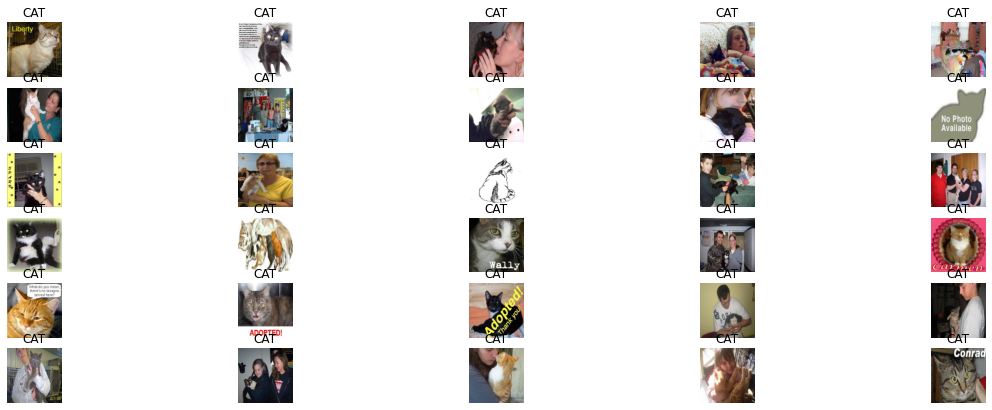

In [241]:
#Plot some of the cats that we have defined as bad and will be removed from the training set. 
cat_bad_idx = [157,149,26,6,3731,3727,3672,3658,3470,3216,3103,3046,2939,2893,2817,2720,2663,2481,2457,2160,2013,2003,1646,1485,1102,973,859,702,230,214,166]

for i in range(len(cat_bad_idx)):
    cat_bad_idx[i] = cat_bad_idx[i]-1


num_images = 5
num_of_rows = math.floor(len(cat_bad_idx) / num_images)
_, axes = plt.subplots(num_of_rows, num_images, figsize=(20, 7))

current_index = 0

for j in range(num_of_rows):
    for i in range(num_images):
        axes[j, i].imshow(cats[cat_bad_idx[current_index]])
        axes[j, i].axis("off")
        axes[j, i].set_title("CAT")
        current_index = current_index + 1
    
plt.show()

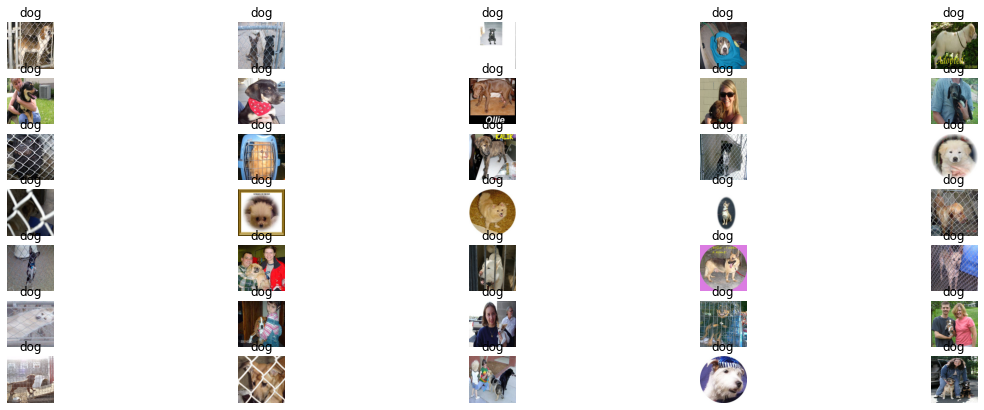

In [242]:
#Plot some of the dogs that we have defined as bad and will be removed from the training set. 
dogs_bad_idx = [3998,3991,3994,3962,3953,3947,3932,3927,3921,3898,3884,3882,3869,3855,3838,3822,3759,3755,3753,3739,3724,3690,3655,3654,3629,3522,3501,3503,3478,3469,3408,3390,3295,3271,3222,3224,3181,3163,3162,3154,3135,3118,3106,3082,3075,3072,3068,3067,3035,2982,2980,2952,2919,2888,2877,2869,2842,2837,2800,2794, 2727,2714,2695,2686,2662,2644,2614,2608,2591,2598,2578,2568,2500,2477,2422,2432,2410,2383,2372,2339,2325,2320,2315,2295,2244,2206,2211,2200,2144,2003,1981,1963,1962,1954,1944,1938,1934,1897,1904,1895,1857,1851,1823,1800,1798,1773,1674,1642,1643,1575,1560,1428,1425,1419,1412,1403,1353,1358,1342,1308,1311,1287,1259,1237,1180,1163,1161,1144,1129,1122,1121,1094,1043,942,862,813,824,814,729,693,689,662,646,647,638,623,599,593,571,545,473,461,410,372,322,226,201,173,81,59,52,43,26]

for i in range(len(dogs_bad_idx)):
    dogs_bad_idx[i] = dogs_bad_idx[i]-1

num_images = 5
num_of_rows = 7
_, axes = plt.subplots(num_of_rows, num_images, figsize=(20, 7))

current_index = 0

for j in range(num_of_rows):
    for i in range(num_images):
        axes[j, i].imshow(dogs[dogs_bad_idx[current_index]])
        axes[j, i].axis("off")
        axes[j, i].set_title("dog")
        current_index = current_index + 1
    
plt.show()

In [244]:
#Remove the bad cats and dogs.

#Cats
filtered_vector_cats = [cats[i] for i in range(len(cats)) if i not in cat_bad_idx]

#Rename the filtered_vector 
cats = filtered_vector_cats

#Dogs
filtered_vector_dogs = [dogs[i] for i in range(len(dogs)) if i not in dogs_bad_idx]

#Rename the filtered_vector 
dogs = filtered_vector_dogs





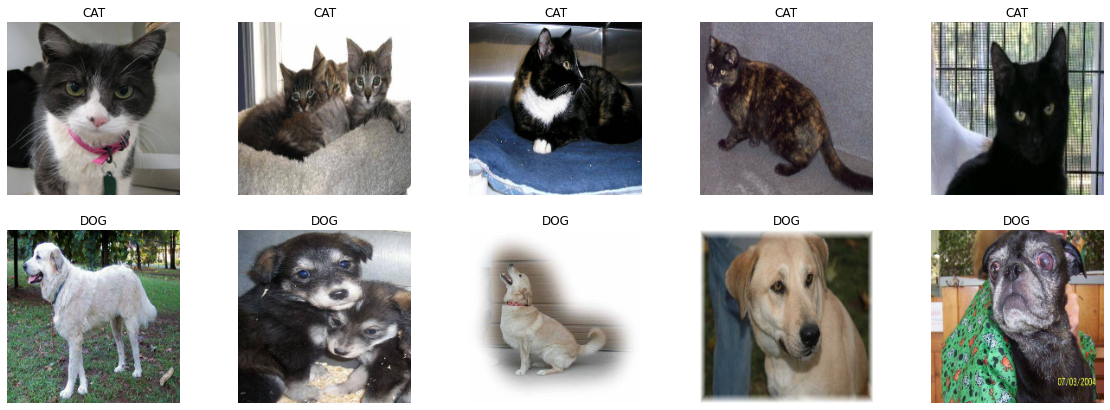

In [245]:
#Print random "good" cats and dogs
num_images = 5
_, axes = plt.subplots(2, num_images, figsize=(20, 7))

for i in range(num_images):
    axes[0, i].imshow(cats[random.randint(0, len(cats)-1)])
    axes[0, i].axis("off")
    axes[0, i].set_title("CAT")
    
    axes[1, i].imshow(dogs[random.randint(0, len(dogs)-1)])
    axes[1, i].axis("off")
    axes[1, i].set_title("DOG")
    
plt.show()

In [246]:
#Create the training set
from sklearn.model_selection import train_test_split

training = cats + dogs
training_labels = [1]*len(cats) + [0]*len(dogs)

train_data, val_data, train_labels, val_labels = train_test_split(training, training_labels, test_size=0.2, random_state=42)
train_data, val_data, train_labels, val_labels = np.array(train_data), np.array(val_data), np.array(train_labels), np.array(val_labels)

#train_data = tf.expand_dims(train_data, axis=-1)
#val_data = tf.expand_dims(val_data, axis=-1)

print(f"Size of train data {train_data.shape}, size of labels {train_labels.shape}")
print(f"Size of validation data {val_data.shape}, size of labels {val_labels.shape}")

images_shape = train_data[0].shape

Size of train data (6104, 200, 200, 3), size of labels (6104,)
Size of validation data (1526, 200, 200, 3), size of labels (1526,)


In [247]:
# Create network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization, AveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=images_shape))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu',kernel_regularizer = 'l2'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu',kernel_regularizer = 'l2'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.40))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_160 (Conv2D)         (None, 198, 198, 32)      896       
                                                                 
 batch_normalization_53 (Bat  (None, 198, 198, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_161 (Conv2D)         (None, 196, 196, 32)      9248      
                                                                 
 max_pooling2d_72 (MaxPoolin  (None, 98, 98, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_162 (Conv2D)         (None, 96, 96, 64)        18496     
                                                                 
 dropout_18 (Dropout)        (None, 96, 96, 64)      

In [248]:
# Train network
history = model.fit(
    x = train_data,
    y = train_labels,
    batch_size = 32,
    epochs = 50,
    validation_data = (val_data, val_labels)
)

Epoch 1/50
191/191 [==============================] - 552s 3s/step - loss: 2.5516 - accuracy: 0.5075 - val_loss: 1.6592 - val_accuracy: 0.5236
Epoch 2/50
 34/191 [====>.........................] - ETA: 6:41 - loss: 1.6356 - accuracy: 0.5138

KeyboardInterrupt: 

In [ ]:
# Evaluate
